In [1]:
import json
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001
MODEL_INIT_PATH = ''
DATA_FOLDER = '/content/drive/MyDrive/datasets/waz_messenger_history'
SAVE_FOLDER = '/content/drive/MyDrive/kodeiro/text_generation/models'

In [4]:
waz_mess_paths = [f'{DATA_FOLDER}/message_6.json',
                  f'{DATA_FOLDER}/message_5.json',
                  f'{DATA_FOLDER}/message_4.json']
                  #'./message_3.json'
                  #'./message_2.json',
                  #'./message_1.json']

In [5]:
def load_data(data_paths):
    corpus = []
    n_messages = 0

    for path in data_paths:
        print(f'Loading {path}')

        with open(path, 'rb') as messages:
            messages = messages.read().decode(encoding='ISO-8859-2')

            messages = json.loads(messages)
            n_messages += len(messages['messages'])
            print(f'{n_messages} messages')

            for i in reversed(range(len(messages["messages"]))):
                line = ''
                sender_name = messages["messages"][i]["sender_name"]

                if sender_name == '':
                    sender_name = 'Jakub Szyma'

                line = line + sender_name + ': '

                try:
                    line = line + messages["messages"][i]["content"]
                    line = line + '\n'
                    corpus.append(line)
                except:
                    continue
    return corpus

In [6]:
corpus = load_data(data_paths=waz_mess_paths)

Loading /content/drive/MyDrive/datasets/waz_messenger_history/message_6.json
10000 messages
Loading /content/drive/MyDrive/datasets/waz_messenger_history/message_5.json
20000 messages
Loading /content/drive/MyDrive/datasets/waz_messenger_history/message_4.json
30000 messages


In [7]:
print(corpus[0:4])

['Bartek Szelag: Jak ci pasuje,', 'Jakub Szyma: Jutro turniej,', 'Jakub Szyma: W srode pewnei jakas joga,', 'Jakub Szyma: W czwartek zas cos sie odkurwi,']


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [9]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[5, 6, 17, 56, 271]

In [10]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    for input_sentence in corpus:
        tokens = tokenizer.texts_to_sequences([input_sentence])[0]
        
        for i in range(1, len(tokens)):
            input_sequences.append(tokens[:i+1])
    
    return input_sequences

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [11]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 183145
maximum length of sequences is: 302


In [12]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = pad_sequences(sequences=input_sequences, maxlen=maxlen)
    
    return padded_sequences

In [13]:
# Padding
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (183145, 302)


In [14]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = []
    labels = []
    one_hot_labels = []

    features, labels = input_sequences[:,:-1], input_sequences[:,-1]
    one_hot_labels = to_categorical(y=labels, num_classes=total_words)

    return features, one_hot_labels

In [15]:
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (183145, 301)
labels have shape: (183145, 21146)


In [30]:
def create_model(total_words, max_sequence_len, learning_rate):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()

    model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
    model.add(Bidirectional(GRU(units=1024, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(units=1024)))
    model.add(Dropout(0.2))
    model.add(Dense(units=total_words, activation='softmax'))

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'val_accuracy'])

    return model

In [31]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/kodeiro/text_generation/models/checkpoint_{epoch:02d}', save_best_only=False, save_freq='epoch')

callbacks = [ckpt_callback]

In [ ]:
if MODEL_INIT_PATH:
    model = tf.keras.models.load_model(MODEL_INIT_PATH)
else:
    model = create_model(total_words, max_sequence_len, LEARNING_RATE)
    
history = model.fit(features, labels, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, 
                    callbacks=callbacks)

Epoch 1/100
716/716 [==============================] - ETA: 0s - loss: 5.9676 - accuracy: 0.2078

716/716 [==============================] - 225s 307ms/step - loss: 5.9676 - accuracy: 0.2078
Epoch 2/100
716/716 [==============================] - ETA: 0s - loss: 6.1702 - accuracy: 0.2184

716/716 [==============================] - 219s 307ms/step - loss: 6.1702 - accuracy: 0.2184
Epoch 3/100
716/716 [==============================] - ETA: 0s - loss: 5.9836 - accuracy: 0.2253

716/716 [==============================] - 220s 307ms/step - loss: 5.9836 - accuracy: 0.2253
Epoch 4/100
716/716 [==============================] - ETA: 0s - loss: 5.5105 - accuracy: 0.2357

716/716 [==============================] - 219s 306ms/step - loss: 5.5105 - accuracy: 0.2357
Epoch 5/100
716/716 [==============================] - ETA: 0s - loss: 5.1355 - accuracy: 0.2453

716/716 [==============================] - 221s 308ms/step - loss: 5.1355 - accuracy: 0.2453
Epoch 6/100
716/716 [==============================] - ETA: 0s - loss: 4.8603 - accuracy: 0.2507

716/716 [==============================] - 220s 307ms/step - loss: 4.8603 - accuracy: 0.2507
Epoch 7/100
716/716 [==============================] - ETA: 0s - loss: 4.5475 - accuracy: 0.2640

716/716 [==============================] - 219s 306ms/step - loss: 4.5475 - accuracy: 0.2640
Epoch 8/100
716/716 [==============================] - ETA: 0s - loss: 4.3656 - accuracy: 0.2787

716/716 [==============================] - 220s 307ms/step - loss: 4.3656 - accuracy: 0.2787
Epoch 9/100
716/716 [==============================] - ETA: 0s - loss: 4.1749 - accuracy: 0.2977

716/716 [==============================] - 221s 308ms/step - loss: 4.1749 - accuracy: 0.2977
Epoch 10/100
716/716 [==============================] - ETA: 0s - loss: 3.9698 - accuracy: 0.3201

716/716 [==============================] - 220s 307ms/step - loss: 3.9698 - accuracy: 0.3201
Epoch 11/100
716/716 [==============================] - ETA: 0s - loss: 3.7798 - accuracy: 0.3432

716/716 [==============================] - 219s 306ms/step - loss: 3.7798 - accuracy: 0.3432
Epoch 12/100
716/716 [==============================] - ETA: 0s - loss: 3.6552 - accuracy: 0.3605

716/716 [==============================] - 221s 308ms/step - loss: 3.6552 - accuracy: 0.3605
Epoch 13/100
716/716 [==============================] - ETA: 0s - loss: 3.5490 - accuracy: 0.3752

716/716 [==============================] - 219s 306ms/step - loss: 3.5490 - accuracy: 0.3752
Epoch 14/100
716/716 [==============================] - ETA: 0s - loss: 3.4693 - accuracy: 0.3878

716/716 [==============================] - 219s 306ms/step - loss: 3.4693 - accuracy: 0.3878
Epoch 15/100
716/716 [==============================] - ETA: 0s - loss: 3.4021 - accuracy: 0.3991

716/716 [==============================] - 220s 307ms/step - loss: 3.4021 - accuracy: 0.3991
Epoch 16/100
716/716 [==============================] - ETA: 0s - loss: 3.7180 - accuracy: 0.3644

716/716 [==============================] - 219s 306ms/step - loss: 3.7180 - accuracy: 0.3644
Epoch 17/100
716/716 [==============================] - ETA: 0s - loss: 3.6819 - accuracy: 0.3629

716/716 [==============================] - 221s 308ms/step - loss: 3.6819 - accuracy: 0.3629
Epoch 18/100
716/716 [==============================] - ETA: 0s - loss: 4.8338 - accuracy: 0.2694

716/716 [==============================] - 219s 306ms/step - loss: 4.8338 - accuracy: 0.2694
Epoch 19/100
716/716 [==============================] - ETA: 0s - loss: 4.5113 - accuracy: 0.2810

716/716 [==============================] - 219s 306ms/step - loss: 4.5113 - accuracy: 0.2810
Epoch 20/100
716/716 [==============================] - ETA: 0s - loss: 4.0941 - accuracy: 0.3132

716/716 [==============================] - 219s 305ms/step - loss: 4.0941 - accuracy: 0.3132
Epoch 21/100
716/716 [==============================] - ETA: 0s - loss: 3.9252 - accuracy: 0.3328

716/716 [==============================] - 218s 304ms/step - loss: 3.9252 - accuracy: 0.3328
Epoch 22/100
716/716 [==============================] - ETA: 0s - loss: 3.7937 - accuracy: 0.3482

716/716 [==============================] - 219s 306ms/step - loss: 3.7937 - accuracy: 0.3482
Epoch 23/100
716/716 [==============================] - ETA: 0s - loss: 3.6602 - accuracy: 0.3626

716/716 [==============================] - 218s 304ms/step - loss: 3.6602 - accuracy: 0.3626
Epoch 24/100
716/716 [==============================] - ETA: 0s - loss: 3.5728 - accuracy: 0.3749

716/716 [==============================] - 219s 306ms/step - loss: 3.5728 - accuracy: 0.3749
Epoch 25/100
716/716 [==============================] - ETA: 0s - loss: 3.4892 - accuracy: 0.3865

716/716 [==============================] - 218s 304ms/step - loss: 3.4892 - accuracy: 0.3865
Epoch 26/100
716/716 [==============================] - ETA: 0s - loss: 3.4290 - accuracy: 0.3964

716/716 [==============================] - 217s 304ms/step - loss: 3.4290 - accuracy: 0.3964
Epoch 27/100
716/716 [==============================] - ETA: 0s - loss: 3.8887 - accuracy: 0.3392

716/716 [==============================] - 220s 307ms/step - loss: 3.8887 - accuracy: 0.3392
Epoch 28/100
716/716 [==============================] - ETA: 0s - loss: 3.6147 - accuracy: 0.3611

716/716 [==============================] - 218s 304ms/step - loss: 3.6147 - accuracy: 0.3611
Epoch 29/100
716/716 [==============================] - ETA: 0s - loss: 3.3698 - accuracy: 0.3916

716/716 [==============================] - 220s 307ms/step - loss: 3.3698 - accuracy: 0.3916
Epoch 30/100
716/716 [==============================] - ETA: 0s - loss: 3.2383 - accuracy: 0.4105

716/716 [==============================] - 218s 304ms/step - loss: 3.2383 - accuracy: 0.4105
Epoch 31/100
716/716 [==============================] - ETA: 0s - loss: 3.1549 - accuracy: 0.4233

716/716 [==============================] - 217s 304ms/step - loss: 3.1549 - accuracy: 0.4233
Epoch 32/100
716/716 [==============================] - ETA: 0s - loss: 3.0823 - accuracy: 0.4339

716/716 [==============================] - 219s 306ms/step - loss: 3.0823 - accuracy: 0.4339
Epoch 33/100
716/716 [==============================] - ETA: 0s - loss: 3.0266 - accuracy: 0.4417

716/716 [==============================] - 217s 303ms/step - loss: 3.0266 - accuracy: 0.4417
Epoch 34/100
716/716 [==============================] - ETA: 0s - loss: 2.9700 - accuracy: 0.4512

716/716 [==============================] - 219s 305ms/step - loss: 2.9700 - accuracy: 0.4512
Epoch 35/100
716/716 [==============================] - ETA: 0s - loss: 2.9171 - accuracy: 0.4589

716/716 [==============================] - 218s 304ms/step - loss: 2.9171 - accuracy: 0.4589
Epoch 36/100
716/716 [==============================] - ETA: 0s - loss: 2.8729 - accuracy: 0.4671

716/716 [==============================] - 218s 304ms/step - loss: 2.8729 - accuracy: 0.4671
Epoch 37/100
716/716 [==============================] - ETA: 0s - loss: 2.8339 - accuracy: 0.4741

716/716 [==============================] - 217s 304ms/step - loss: 2.8339 - accuracy: 0.4741
Epoch 38/100
716/716 [==============================] - ETA: 0s - loss: 2.8086 - accuracy: 0.4788

716/716 [==============================] - 218s 304ms/step - loss: 2.8086 - accuracy: 0.4788
Epoch 39/100
716/716 [==============================] - ETA: 0s - loss: 2.7779 - accuracy: 0.4828

716/716 [==============================] - 219s 306ms/step - loss: 2.7779 - accuracy: 0.4828
Epoch 40/100
716/716 [==============================] - ETA: 0s - loss: 2.7523 - accuracy: 0.4874

716/716 [==============================] - 217s 303ms/step - loss: 2.7523 - accuracy: 0.4874
Epoch 41/100
716/716 [==============================] - ETA: 0s - loss: 2.7228 - accuracy: 0.4929

716/716 [==============================] - 219s 306ms/step - loss: 2.7228 - accuracy: 0.4929
Epoch 42/100
716/716 [==============================] - ETA: 0s - loss: 2.7046 - accuracy: 0.4959

716/716 [==============================] - 217s 304ms/step - loss: 2.7046 - accuracy: 0.4959
Epoch 43/100
716/716 [==============================] - ETA: 0s - loss: 2.6831 - accuracy: 0.4989

716/716 [==============================] - 218s 304ms/step - loss: 2.6831 - accuracy: 0.4989
Epoch 44/100
716/716 [==============================] - ETA: 0s - loss: 2.6634 - accuracy: 0.5041

716/716 [==============================] - 219s 306ms/step - loss: 2.6634 - accuracy: 0.5041
Epoch 45/100
716/716 [==============================] - ETA: 0s - loss: 2.6465 - accuracy: 0.5056

716/716 [==============================] - 218s 304ms/step - loss: 2.6465 - accuracy: 0.5056
Epoch 46/100
716/716 [==============================] - ETA: 0s - loss: 2.6260 - accuracy: 0.5087

716/716 [==============================] - 217s 304ms/step - loss: 2.6260 - accuracy: 0.5087
Epoch 47/100
716/716 [==============================] - ETA: 0s - loss: 2.5991 - accuracy: 0.5140

716/716 [==============================] - 218s 304ms/step - loss: 2.5991 - accuracy: 0.5140
Epoch 48/100
716/716 [==============================] - ETA: 0s - loss: 2.5961 - accuracy: 0.5148

716/716 [==============================] - 218s 304ms/step - loss: 2.5961 - accuracy: 0.5148
Epoch 49/100
716/716 [==============================] - ETA: 0s - loss: 2.5809 - accuracy: 0.5174

716/716 [==============================] - 220s 307ms/step - loss: 2.5809 - accuracy: 0.5174
Epoch 50/100
716/716 [==============================] - ETA: 0s - loss: 2.5599 - accuracy: 0.5221

716/716 [==============================] - 217s 304ms/step - loss: 2.5599 - accuracy: 0.5221
Epoch 51/100
716/716 [==============================] - ETA: 0s - loss: 2.5357 - accuracy: 0.5239

716/716 [==============================] - 219s 306ms/step - loss: 2.5357 - accuracy: 0.5239
Epoch 52/100
716/716 [==============================] - ETA: 0s - loss: 2.5161 - accuracy: 0.5287

716/716 [==============================] - 218s 304ms/step - loss: 2.5161 - accuracy: 0.5287
Epoch 53/100
716/716 [==============================] - ETA: 0s - loss: 2.5051 - accuracy: 0.5303

716/716 [==============================] - 218s 304ms/step - loss: 2.5051 - accuracy: 0.5303
Epoch 54/100
716/716 [==============================] - ETA: 0s - loss: 2.4864 - accuracy: 0.5339

716/716 [==============================] - 217s 303ms/step - loss: 2.4864 - accuracy: 0.5339
Epoch 55/100
716/716 [==============================] - ETA: 0s - loss: 2.4760 - accuracy: 0.5361

716/716 [==============================] - 218s 305ms/step - loss: 2.4760 - accuracy: 0.5361
Epoch 56/100
716/716 [==============================] - ETA: 0s - loss: 2.4570 - accuracy: 0.5394

716/716 [==============================] - 220s 308ms/step - loss: 2.4570 - accuracy: 0.5394
Epoch 57/100
716/716 [==============================] - ETA: 0s - loss: 2.4423 - accuracy: 0.5413

716/716 [==============================] - 218s 305ms/step - loss: 2.4423 - accuracy: 0.5413
Epoch 58/100
716/716 [==============================] - ETA: 0s - loss: 2.4299 - accuracy: 0.5446

716/716 [==============================] - 218s 305ms/step - loss: 2.4299 - accuracy: 0.5446
Epoch 59/100
716/716 [==============================] - ETA: 0s - loss: 2.4191 - accuracy: 0.5465

716/716 [==============================] - 220s 307ms/step - loss: 2.4191 - accuracy: 0.5465
Epoch 60/100
716/716 [==============================] - ETA: 0s - loss: 2.4044 - accuracy: 0.5493

716/716 [==============================] - 218s 305ms/step - loss: 2.4044 - accuracy: 0.5493
Epoch 61/100
716/716 [==============================] - ETA: 0s - loss: 2.3967 - accuracy: 0.5496

716/716 [==============================] - 220s 308ms/step - loss: 2.3967 - accuracy: 0.5496
Epoch 62/100
716/716 [==============================] - ETA: 0s - loss: 2.3806 - accuracy: 0.5525

716/716 [==============================] - 218s 305ms/step - loss: 2.3806 - accuracy: 0.5525
Epoch 63/100
716/716 [==============================] - ETA: 0s - loss: 2.3764 - accuracy: 0.5538

716/716 [==============================] - 218s 305ms/step - loss: 2.3764 - accuracy: 0.5538
Epoch 64/100
716/716 [==============================] - ETA: 0s - loss: 2.3626 - accuracy: 0.5560

716/716 [==============================] - 218s 305ms/step - loss: 2.3626 - accuracy: 0.5560
Epoch 65/100
716/716 [==============================] - ETA: 0s - loss: 2.3519 - accuracy: 0.5581

716/716 [==============================] - 218s 305ms/step - loss: 2.3519 - accuracy: 0.5581
Epoch 66/100
716/716 [==============================] - ETA: 0s - loss: 2.3456 - accuracy: 0.5604

716/716 [==============================] - 220s 307ms/step - loss: 2.3456 - accuracy: 0.5604
Epoch 67/100
716/716 [==============================] - ETA: 0s - loss: 2.3354 - accuracy: 0.5613

716/716 [==============================] - 218s 305ms/step - loss: 2.3354 - accuracy: 0.5613
Epoch 68/100
716/716 [==============================] - ETA: 0s - loss: 2.3261 - accuracy: 0.5631

716/716 [==============================] - 218s 305ms/step - loss: 2.3261 - accuracy: 0.5631
Epoch 69/100
716/716 [==============================] - ETA: 0s - loss: 2.3198 - accuracy: 0.5642

716/716 [==============================] - 218s 305ms/step - loss: 2.3198 - accuracy: 0.5642
Epoch 70/100
716/716 [==============================] - ETA: 0s - loss: 2.3147 - accuracy: 0.5656

716/716 [==============================] - 218s 305ms/step - loss: 2.3147 - accuracy: 0.5656
Epoch 71/100
716/716 [==============================] - ETA: 0s - loss: 2.3014 - accuracy: 0.5673

716/716 [==============================] - 220s 307ms/step - loss: 2.3014 - accuracy: 0.5673
Epoch 72/100
716/716 [==============================] - ETA: 0s - loss: 2.3036 - accuracy: 0.5664

716/716 [==============================] - 218s 305ms/step - loss: 2.3036 - accuracy: 0.5664
Epoch 73/100
716/716 [==============================] - ETA: 0s - loss: 2.2936 - accuracy: 0.5690

716/716 [==============================] - 220s 308ms/step - loss: 2.2936 - accuracy: 0.5690
Epoch 74/100
716/716 [==============================] - ETA: 0s - loss: 2.2855 - accuracy: 0.5705

716/716 [==============================] - 218s 305ms/step - loss: 2.2855 - accuracy: 0.5705
Epoch 75/100
716/716 [==============================] - ETA: 0s - loss: 2.2767 - accuracy: 0.5722

716/716 [==============================] - 218s 305ms/step - loss: 2.2767 - accuracy: 0.5722
Epoch 76/100
716/716 [==============================] - ETA: 0s - loss: 2.2805 - accuracy: 0.5702

716/716 [==============================] - 220s 307ms/step - loss: 2.2805 - accuracy: 0.5702
Epoch 77/100
716/716 [==============================] - ETA: 0s - loss: 2.2724 - accuracy: 0.5714

716/716 [==============================] - 218s 305ms/step - loss: 2.2724 - accuracy: 0.5714
Epoch 78/100
716/716 [==============================] - ETA: 0s - loss: 2.2642 - accuracy: 0.5740

716/716 [==============================] - 218s 304ms/step - loss: 2.2642 - accuracy: 0.5740
Epoch 79/100
716/716 [==============================] - ETA: 0s - loss: 2.2559 - accuracy: 0.5750

716/716 [==============================] - 218s 305ms/step - loss: 2.2559 - accuracy: 0.5750
Epoch 80/100
716/716 [==============================] - ETA: 0s - loss: 2.2542 - accuracy: 0.5763

716/716 [==============================] - 218s 305ms/step - loss: 2.2542 - accuracy: 0.5763
Epoch 81/100
716/716 [==============================] - ETA: 0s - loss: 2.2477 - accuracy: 0.5762

716/716 [==============================] - 220s 308ms/step - loss: 2.2477 - accuracy: 0.5762
Epoch 82/100
716/716 [==============================] - ETA: 0s - loss: 2.2400 - accuracy: 0.5776

716/716 [==============================] - 219s 305ms/step - loss: 2.2400 - accuracy: 0.5776
Epoch 83/100
716/716 [==============================] - ETA: 0s - loss: 2.2412 - accuracy: 0.5778

716/716 [==============================] - 220s 308ms/step - loss: 2.2412 - accuracy: 0.5778
Epoch 84/100
716/716 [==============================] - ETA: 0s - loss: 2.2418 - accuracy: 0.5782

716/716 [==============================] - 218s 305ms/step - loss: 2.2418 - accuracy: 0.5782
Epoch 85/100
716/716 [==============================] - ETA: 0s - loss: 2.2346 - accuracy: 0.5804

716/716 [==============================] - 218s 305ms/step - loss: 2.2346 - accuracy: 0.5804
Epoch 86/100
716/716 [==============================] - ETA: 0s - loss: 2.2225 - accuracy: 0.5810

716/716 [==============================] - 220s 307ms/step - loss: 2.2225 - accuracy: 0.5810
Epoch 87/100
716/716 [==============================] - ETA: 0s - loss: 2.2293 - accuracy: 0.5792

716/716 [==============================] - 220s 307ms/step - loss: 2.2293 - accuracy: 0.5792
Epoch 88/100
716/716 [==============================] - ETA: 0s - loss: 2.2143 - accuracy: 0.5825

716/716 [==============================] - 220s 307ms/step - loss: 2.2143 - accuracy: 0.5825
Epoch 89/100
 98/716 [===>..........................] - ETA: 2:51 - loss: 2.0843 - accuracy: 0.5996

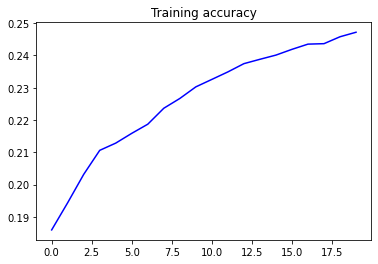

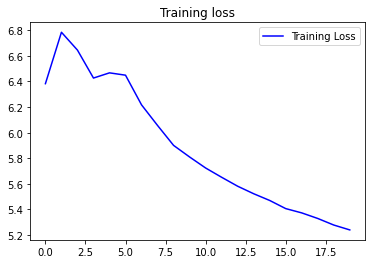

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
seed_text = ""
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict(token_list, verbose=0)
	predicted = np.argmax(predicted, axis=-1).item()
	output_word = tokenizer.index_word[predicted]
	seed_text += " " + output_word

print(seed_text)

Bartek Szelag no to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma to nie ma
